# Лабораторная работа 6

**Внимание!** Данную лабораторную нужно выполнять на **Python 3.6+**.

## 1. Работа с метаклассами

### Задание 1.1 (0.6 балла)

Реализуйте метакласс **BoundedMeta**, который контролирует количество созданных объектов классов, которые имеют данный метакласс. Допустимое количество объектов задайте параметром (по умолчанию 1).

В случае превышения бросайте исключение **TypeError**. Eсли значение параметра - **None**, то ограничений нету.

Другими словами, у класса **C** с метаклассом **BoundedMeta** должно быть создано не более 2 экземпляров. 

In [1]:
class BoundedMeta(type): 
    def __new__(mcs, name, bases, attrs, max_instance_count=1):
        return super().__new__(mcs, name, bases, attrs)
    
    def __init__(cls, name, bases, attrs, max_instance_count=1):
        cls.__instance_count = 0
        cls.__max_instance_count = max_instance_count
        return super().__init__(name, bases, attrs)
    
    def __call__(cls):
        if cls.__max_instance_count is None or cls.__instance_count < cls.__max_instance_count:
            cls.__instance_count += 1
            return super().__call__()
        
        raise TypeError()


class C(metaclass=BoundedMeta, max_instance_count=2):
    pass

class F(metaclass=BoundedMeta, max_instance_count=1):
    pass

c1 = C()
c2 = C()

try:
    c3 = C()
except TypeError:
    print('everything works fine!')
else:
    print('something goes wrong!')

f1 = F()

try:
    f2 = F()
except TypeError:
    print('everything works fine!')
else:
    print('something goes wrong!')

everything works fine!
everything works fine!


### Задание 1.2 (0.6 балла)

Реализуйте класс **BoundedBase**, в котором определен абстрактный classmethod get_max_instance_count, возвращающий максимальное количество экзмепляров, которые можно создать.

Не допускайте ***создания*** объекта, если данное значение превышено - бросайте исключение **TypeError**. Значение, равное **None** - без ограничений.

In [2]:
from abc import ABCMeta, abstractclassmethod


class BoundedBase:
    __metaclass__ = ABCMeta
    __instance_count = 0
    
    def __new__(cls):
        cls.__instance_count += 1
        
        if cls.__instance_count > cls.get_max_instance_count():
            raise TypeError()
        
        return super().__new__(cls)
    
    @abstractclassmethod
    def get_max_instance_count(cls):
        pass
    


class D(BoundedBase):
    @classmethod
    def get_max_instance_count(cls):
        return 1

class E(BoundedBase):
    @classmethod
    def get_max_instance_count(cls):
        return 2
    
d1 = D()

try:
    d2 = D()
except TypeError:
    print('everything works fine!')
else:
    print('something goes wrong!')

e1 = E()
e2 = E()

try:
    e3 = E()
except TypeError:
    print('everything works fine!')
else:
    print('something goes wrong!')

everything works fine!
everything works fine!


## 2. Работа с NumPy и SciPy

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \frac1{N}\sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но в этой задаче положим $\mathbf{C = 10^{-3}}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$.

In [3]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [4]:
sample_size, features_count = 25, 10
C = 0.001
w = np.random.random(features_count)
X, y = np.random.random((sample_size, features_count)), 2 * (np.random.randint(0, 2, sample_size) - 0.5)

### Задание 2.1 (0.2 балла)

In [5]:
XY = np.hstack((X, y[:, np.newaxis]))
del X, y

Немного поработаем с ndarray. Получите из массива XY обратно X и y.

In [6]:
X, y = XY[:, :-1], XY[:, -1]

### Задание 2.2 (0.2 балла)

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $\exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [7]:
def logistic(w, X, y):
    """
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float 
    """
    return np.average(np.logaddexp(0, -y * np.dot(X, w))) + np.sum(w * w) * C / 2

### Задание 2.3.1 (0.3 балла)

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций.

Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

In [8]:
def logistic_grad(w, X, y):
    """
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    """
    n, d = X.shape
    return -np.dot(X.T, y * (1.0 - special.expit(y * np.dot(X, w)))) / n + w * C

In [9]:
assert(logistic_grad(w, X, y).shape == w.shape)

In [10]:
def fit(w, X, y, lr, eps=10e-5, log_show=True):    
    i, delta_loss = 0, np.inf
    history = []
    while delta_loss >= eps:
        before_loss = logistic(w, X, y) 
        w = w - lr * logistic_grad(w, X, y)
        after_loss = logistic(w, X, y)
        delta_loss = np.abs(after_loss - before_loss)
        
        history.append(before_loss)
        if log_show and i % 100 == 0:
            print("Iter: %d, Loss: %f, Loss delta: %f" % (i, before_loss, delta_loss))
        
        i += 1
    
    return w, history

weights, history = fit(w, X, y, 0.001)

Iter: 0, Loss: 1.364690, Loss delta: 0.000467
Iter: 100, Loss: 1.318759, Loss delta: 0.000451
Iter: 200, Loss: 1.274496, Loss delta: 0.000434
Iter: 300, Loss: 1.231987, Loss delta: 0.000416
Iter: 400, Loss: 1.191308, Loss delta: 0.000397
Iter: 500, Loss: 1.152527, Loss delta: 0.000378
Iter: 600, Loss: 1.115699, Loss delta: 0.000358
Iter: 700, Loss: 1.080866, Loss delta: 0.000338
Iter: 800, Loss: 1.048052, Loss delta: 0.000318
Iter: 900, Loss: 1.017269, Loss delta: 0.000298
Iter: 1000, Loss: 0.988509, Loss delta: 0.000277
Iter: 1100, Loss: 0.961749, Loss delta: 0.000258
Iter: 1200, Loss: 0.936949, Loss delta: 0.000238
Iter: 1300, Loss: 0.914057, Loss delta: 0.000220
Iter: 1400, Loss: 0.893004, Loss delta: 0.000201
Iter: 1500, Loss: 0.873712, Loss delta: 0.000184
Iter: 1600, Loss: 0.856093, Loss delta: 0.000168
Iter: 1700, Loss: 0.840053, Loss delta: 0.000153
Iter: 1800, Loss: 0.825491, Loss delta: 0.000138
Iter: 1900, Loss: 0.812307, Loss delta: 0.000125
Iter: 2000, Loss: 0.800398, Loss

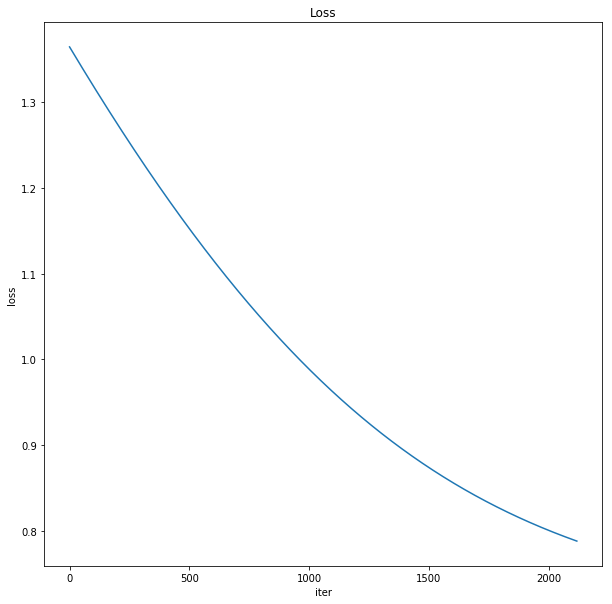

In [11]:
plt.figure(figsize=(10, 10))
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(history)

### Задание 2.3.2 (0.3 балла)

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \varepsilon \cdot e_i) - f(x)}{\varepsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

In [12]:
def max_error(a, b): 
    return np.max(np.abs(a - b))


def grad_finite_diff(func, w, eps=10e-8):
    """
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    """
    d, = w.shape
    e = np.eye(d)
    return np.apply_along_axis(lambda _: (func(w + _ * eps) - func(w)) / eps, 1, e)

In [13]:
mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая!')

err =  3.13158590726e-09 ok


### Задание 2.4.1 (0.4 балла)

Для некоторых задач оптимизации очень удобно использовать гессиан.

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. Эффективно запрограммируйте вычисление гессиана.

In [14]:
def logistic_hess(w, X, y):
    """
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    """
    n, d = X.shape
    D = np.diag(special.expit(y * np.dot(X, w)) * (1.0 - special.expit(y * np.dot(X, w))))
    
    return np.dot(np.dot(X.T, (y * y) * D), X) / n + (np.eye(d) * C)

In [15]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

### Задание 2.4.2 (0.4 балла)

Теперь проверим правильность реализации подсчёта гессиана.

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \varepsilon \cdot e_i + \varepsilon \cdot e_j) -f(x + \varepsilon \cdot e_i) - f(x + \varepsilon \cdot e_j)+ f(x)}{\varepsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\varepsilon \approx 10^{-4}$

In [16]:
def get_e(i, val, size):
        e = np.zeros(size)
        e[i] = val
        return e


def hess_finite_diff(func, w, eps=1e-4):    
    """
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    """
        
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    d = w.size
    hess = np.ndarray((d, d))
    
    for i in range(d):
        for j in range(d):
            ei = get_e(i, eps, d)
            ej = get_e(j, eps, d)
            hess[i][j] = (func(w + ei + ej) - func(w + ei) - func(w + ej) + fval) / eps / eps
    
    return hess

In [17]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-4 else 'ошибка очень большая!')

err =  1.656523909e-06
ok
